In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import EasyEnsembleClassifier

## Problem Statement

The problem we are trying to address here is a (binary) classification problem. We have a dataset that has the payment history of a particular account holder, along with other relevant banking metrics. Using this data we need to predict whether a particular account holder will default on their payment in the next month or not.

## Dataset EDA

In [2]:
file = 'default of credit card clients.xls'

df = pd.read_excel(file)

# Drop the first column from the DataFrame
df.drop(df.columns[0], axis=1, inplace=True)

# Replace the column names with the values from the second row
new_column_names = df.iloc[0]
df.columns = new_column_names

# Resetting the index
df = df.iloc[1:].reset_index(drop=True)

df = df.rename(columns={"default payment next month": "Y"})

# Display the DataFrame with the updated column names
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LIMIT_BAL  30000 non-null  object
 1   SEX        30000 non-null  object
 2   EDUCATION  30000 non-null  object
 3   MARRIAGE   30000 non-null  object
 4   AGE        30000 non-null  object
 5   PAY_0      30000 non-null  object
 6   PAY_2      30000 non-null  object
 7   PAY_3      30000 non-null  object
 8   PAY_4      30000 non-null  object
 9   PAY_5      30000 non-null  object
 10  PAY_6      30000 non-null  object
 11  BILL_AMT1  30000 non-null  object
 12  BILL_AMT2  30000 non-null  object
 13  BILL_AMT3  30000 non-null  object
 14  BILL_AMT4  30000 non-null  object
 15  BILL_AMT5  30000 non-null  object
 16  BILL_AMT6  30000 non-null  object
 17  PAY_AMT1   30000 non-null  object
 18  PAY_AMT2   30000 non-null  object
 19  PAY_AMT3   30000 non-null  object
 20  PAY_AMT4   30000 non-null  o

In [4]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,...,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,81,2,7,4,56,11,11,11,11,10,...,21548,21010,20604,7943,7899,7518,6937,6897,6939,2
top,50000,2,2,2,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,3365,18112,14030,15964,1605,14737,15730,15764,16455,16947,...,3195,3506,4020,5249,5396,5968,6408,6703,7173,23364


In [5]:
# Average Payment Delay
df['avg_payment_delay'] = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)

# Outstanding Balance for each month
for i in range(1, 7):
    df[f'outstanding_balance_{i}'] = df[f'BILL_AMT{i}'] - df[f'PAY_AMT{i}']

# Credit Utilization for each month
for i in range(1, 7):
    df[f'credit_utilization_{i}'] = df[f'BILL_AMT{i}'] / df['LIMIT_BAL']

# Replacing any infinity values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Debt Ratio for each month
for i in range(1, 7):
    # Avoid division by zero
    df[f'debt_ratio_{i}'] = (df[f'BILL_AMT{i}'] - df[f'PAY_AMT{i}']) / df[f'BILL_AMT{i}']
    df.loc[df[f'BILL_AMT{i}'] == 0, f'debt_ratio_{i}'] = 0

# Age Binning
age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
df['age_group'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)

# Consistent Bill Amount
df['consistent_bill_amount'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].std(axis=1)

# List of columns to drop
columns_to_drop = ['AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

df.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,Y,avg_payment_delay,outstanding_balance_1,outstanding_balance_2,outstanding_balance_3,outstanding_balance_4,...,credit_utilization_5,credit_utilization_6,debt_ratio_1,debt_ratio_2,debt_ratio_3,debt_ratio_4,debt_ratio_5,debt_ratio_6,age_group,consistent_bill_amount
0,20000,2,2,1,1,-0.333333,3913,2413,689,0,...,0.000000,0.000000,1.000000,0.777885,1.000000,0.000000,0.000000,0.000000,20-30,1761.633219
1,120000,2,2,2,1,0.500000,2682,725,1682,2272,...,0.028792,0.027175,1.000000,0.420290,0.627144,0.694377,1.000000,0.386691,20-30,637.967841
2,90000,2,2,2,0,0.000000,27721,12527,12559,13331,...,0.166089,0.172767,0.948083,0.893063,0.926248,0.930221,0.933101,0.678436,30-40,6064.518593
3,50000,2,2,1,0,0.000000,44990,46214,48091,27214,...,0.579180,0.590940,0.957438,0.958141,0.975655,0.961150,0.963086,0.966156,30-40,10565.793518
4,50000,1,2,1,0,-0.333333,6617,-31011,25835,11940,...,0.382920,0.382620,0.767901,-5.469312,0.720943,0.570201,0.964013,0.964508,50-60,10668.590074
5,50000,1,1,2,0,0.000000,61900,55254,56951,18394,...,0.392380,0.400480,0.961180,0.968196,0.988595,0.948438,0.949029,0.960048,30-40,22068.949070
6,500000,1,1,2,0,0.000000,312965,372023,407007,522414,...,0.966006,0.947888,0.850529,0.902918,0.914608,0.962704,0.971532,0.970946,20-30,60569.293132
7,100000,2,2,2,0,-0.500000,11496,-221,601,-360,...,-0.001590,0.005670,0.968003,-0.581579,1.000000,-1.628959,11.610063,-1.719577,20-30,4725.009108
8,140000,2,3,1,0,0.333333,7956,14096,11676,11211,...,0.084236,0.026564,0.705007,1.000000,0.964321,0.918107,0.915204,0.731111,20-30,3630.397921
9,20000,1,3,2,0,-1.666667,0,0,0,-13007,...,0.650350,0.695600,0.000000,0.000000,0.000000,0.000000,0.913739,1.000000,30-40,6956.345298


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LIMIT_BAL               30000 non-null  int64   
 1   SEX                     30000 non-null  int64   
 2   EDUCATION               30000 non-null  int64   
 3   MARRIAGE                30000 non-null  int64   
 4   Y                       30000 non-null  int64   
 5   avg_payment_delay       30000 non-null  float64 
 6   outstanding_balance_1   30000 non-null  int64   
 7   outstanding_balance_2   30000 non-null  int64   
 8   outstanding_balance_3   30000 non-null  int64   
 9   outstanding_balance_4   30000 non-null  int64   
 10  outstanding_balance_5   30000 non-null  int64   
 11  outstanding_balance_6   30000 non-null  int64   
 12  credit_utilization_1    30000 non-null  float64 
 13  credit_utilization_2    30000 non-null  float64 
 14  credit_utilization_3  

In [7]:
# Check for missing values in the DataFrame
df.isnull().sum()

0
LIMIT_BAL                 0
SEX                       0
EDUCATION                 0
MARRIAGE                  0
Y                         0
avg_payment_delay         0
outstanding_balance_1     0
outstanding_balance_2     0
outstanding_balance_3     0
outstanding_balance_4     0
outstanding_balance_5     0
outstanding_balance_6     0
credit_utilization_1      0
credit_utilization_2      0
credit_utilization_3      0
credit_utilization_4      0
credit_utilization_5      0
credit_utilization_6      0
debt_ratio_1              0
debt_ratio_2              0
debt_ratio_3              0
debt_ratio_4              0
debt_ratio_5              0
debt_ratio_6              0
age_group                 0
consistent_bill_amount    0
dtype: int64

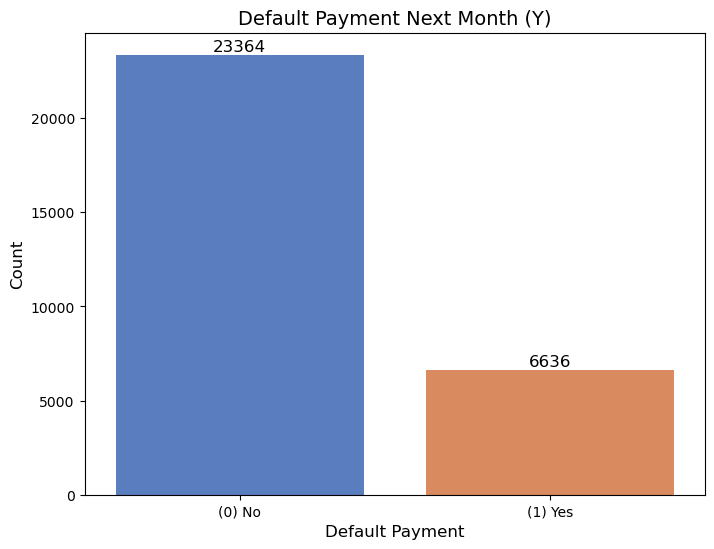

In [8]:
# Count of each class in 'Y' column
y_counts = df['Y'].value_counts()

plt.figure(figsize=(8,6))  # Set the figure size
sns.barplot(x=y_counts.index, y=y_counts.values, palette="muted")  # Create a barplot

plt.title('Default Payment Next Month (Y)', fontsize=14)  # Set the title and its fontsize
plt.xlabel('Default Payment', fontsize=12)  # Set x-axis label and its fontsize
plt.ylabel('Count', fontsize=12)  # Set y-axis label and its fontsize

# Annotate the heights of bars for better visual understanding
for i, v in enumerate(y_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

plt.xticks(ticks=[0, 1], labels=['(0) No', '(1) Yes'])  # Replace 0,1 labels with No and Yes for better understanding
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LIMIT_BAL               30000 non-null  int64   
 1   SEX                     30000 non-null  int64   
 2   EDUCATION               30000 non-null  int64   
 3   MARRIAGE                30000 non-null  int64   
 4   Y                       30000 non-null  int64   
 5   avg_payment_delay       30000 non-null  float64 
 6   outstanding_balance_1   30000 non-null  int64   
 7   outstanding_balance_2   30000 non-null  int64   
 8   outstanding_balance_3   30000 non-null  int64   
 9   outstanding_balance_4   30000 non-null  int64   
 10  outstanding_balance_5   30000 non-null  int64   
 11  outstanding_balance_6   30000 non-null  int64   
 12  credit_utilization_1    30000 non-null  float64 
 13  credit_utilization_2    30000 non-null  float64 
 14  credit_utilization_3  

/var/folders/ds/5xnp18cs5knb1_1qlw5t3xvr0000gn/T/ipykernel_88801/1454876902.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


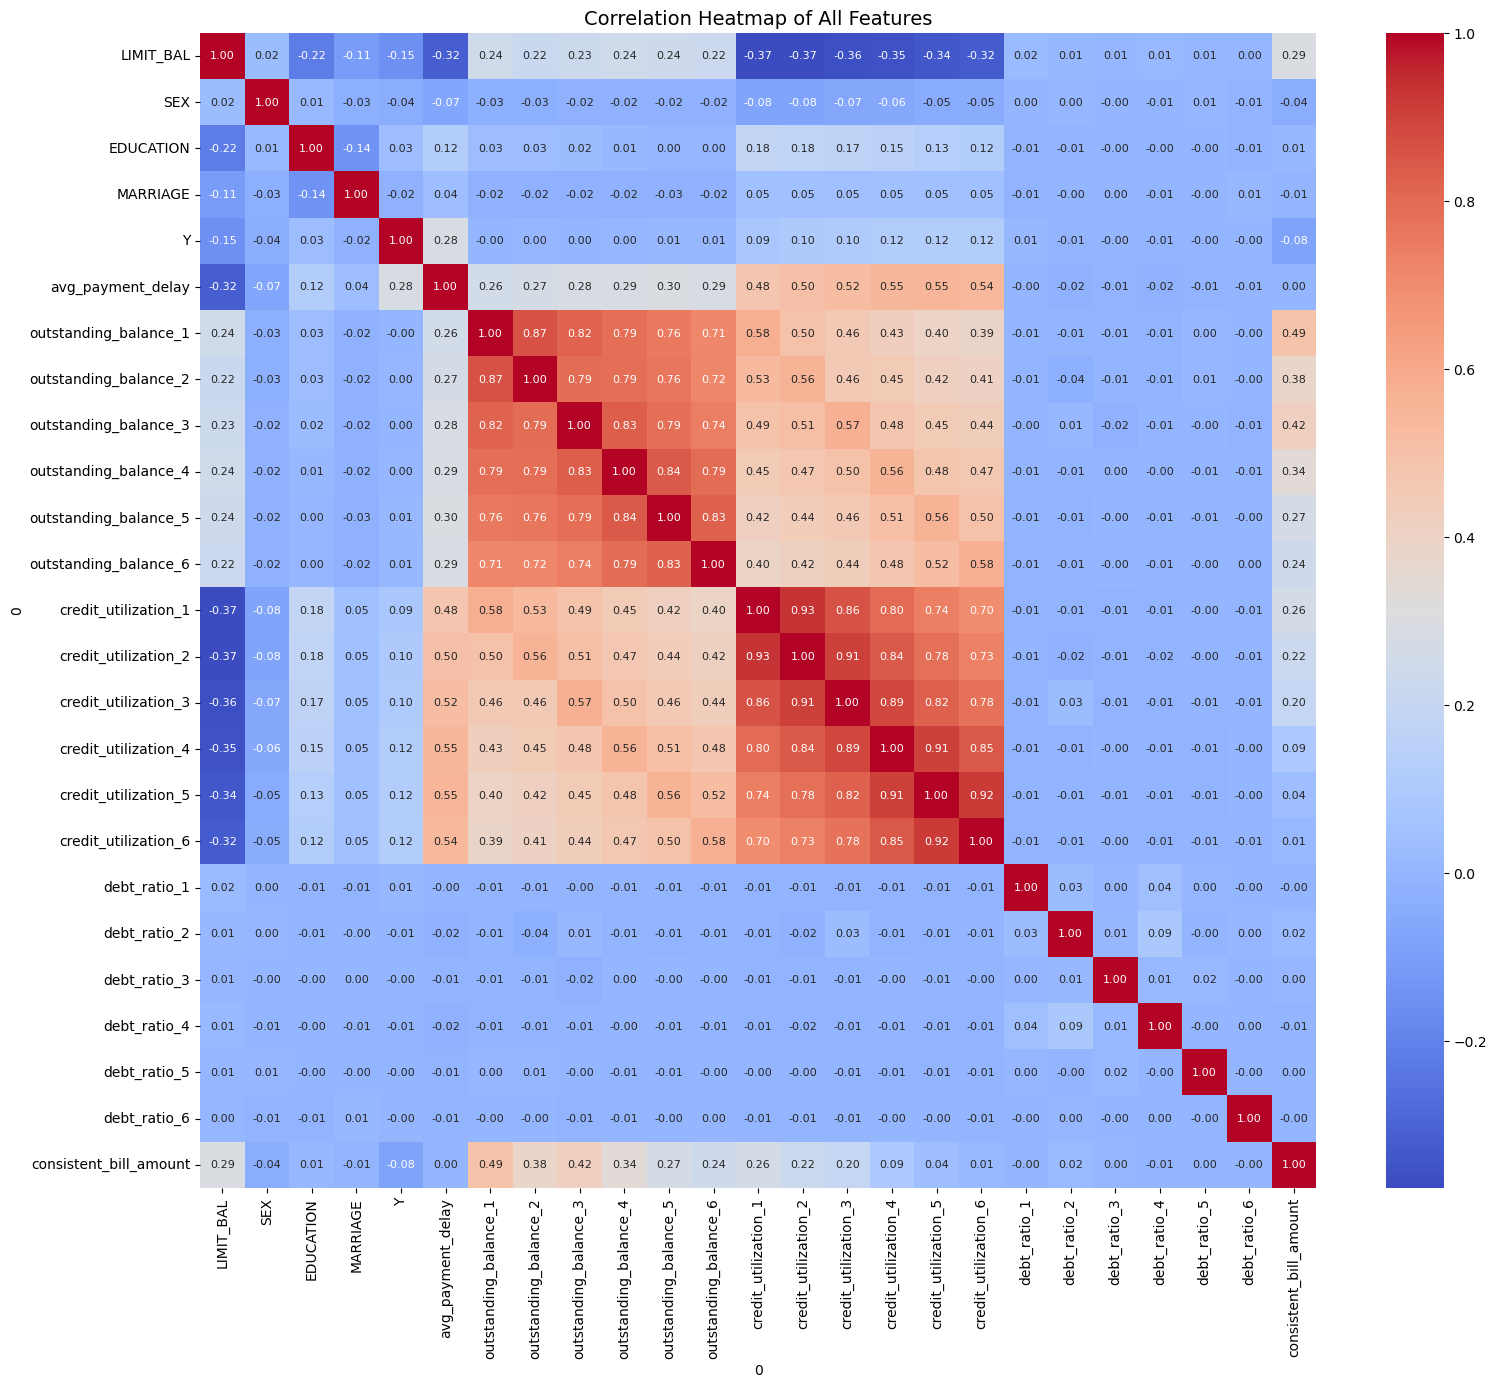

In [10]:
# Compute correlation matrix for all features
correlation_matrix = df.corr()

# Set up the figure size
plt.figure(figsize=(18, 15))

# Create a heatmap with reduced font size in annotations and set a threshold for displaying annotations
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={'size': 8})

# Add a title to the plot
plt.title('Correlation Heatmap of All Features', fontsize=14)

# Show the plot
plt.show()


/var/folders/ds/5xnp18cs5knb1_1qlw5t3xvr0000gn/T/ipykernel_88801/1457635360.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


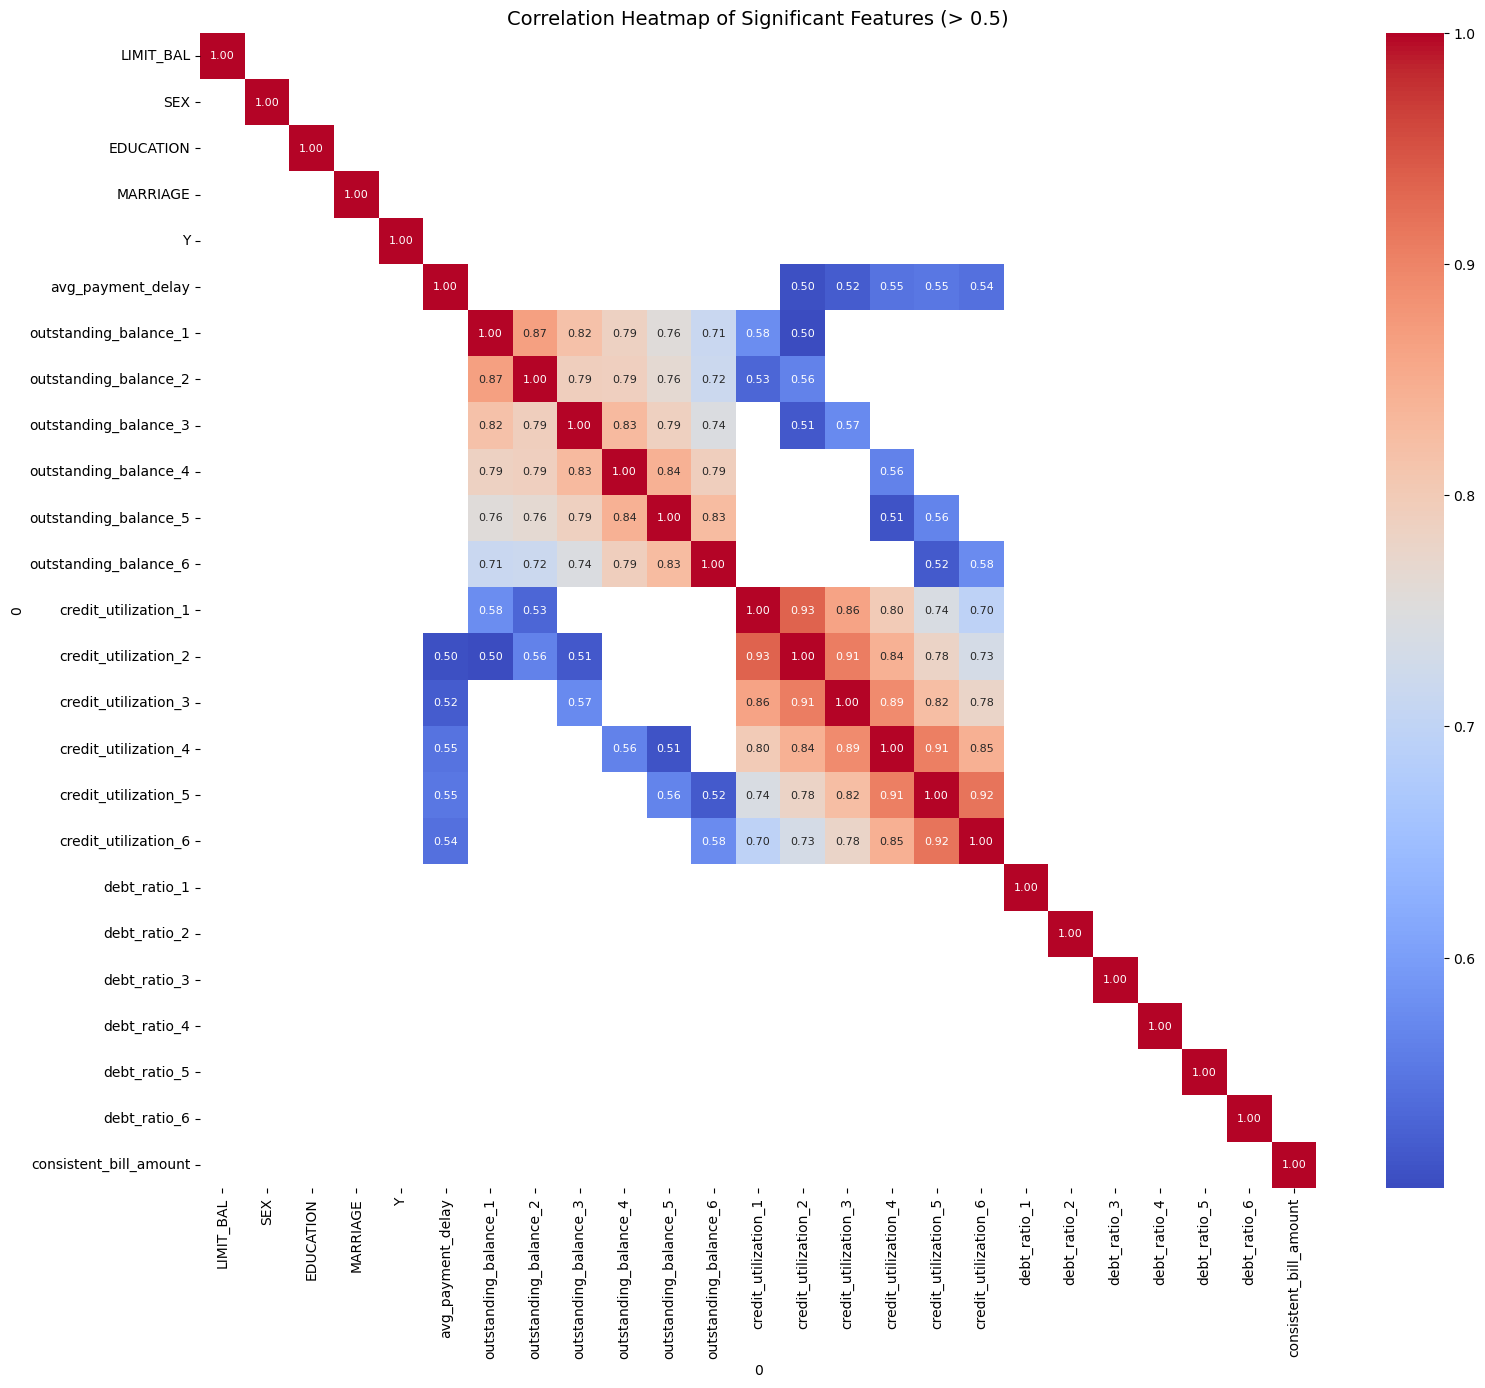

In [11]:
# Compute correlation matrix for all features
correlation_matrix = df.corr()

# Set a threshold for significant correlations
threshold = 0.5

# Mask the values that are below the threshold
mask = np.abs(correlation_matrix) < threshold

plt.figure(figsize=(18, 15))

# Create a heatmap with masked insignificant correlations, and reduced font size in annotations
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={'size': 8})

plt.title('Correlation Heatmap of Significant Features (> 0.5)', fontsize=14)
plt.show()

## Model Selection and Confusion Matrices

In [12]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Support Vector Machines': LinearSVC(max_iter=10000, C=10),
    'Decision Trees': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Random Forest': RandomForestClassifier(),
    'EasyEnsemble': EasyEnsembleClassifier(n_estimators = 200)
}

# Identify categorical and numerical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'age_group']
numeric_cols = df.columns.drop(cat_cols + ["Y"]).tolist()

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Y', axis=1), df['Y'], test_size=0.2, random_state=42)

# Convert y_train and y_test to integer
y_train = y_train.astype('int')
y_test = y_test.astype('int')

for model_name, model in models.items():
    X_train_temp = X_train.copy()
    y_train_temp = y_train.copy()
    X_test_temp = X_test.copy()
    y_test_temp = y_test.copy()

    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               (model_name, model)])

    # Fit the model
    pipeline.fit(X_train_temp, y_train_temp)

    # Make predictions
    y_pred = pipeline.predict(X_test_temp)

    # Print accuracy
    print(f'Accuracy of {model_name}: {accuracy_score(y_test_temp, y_pred)}')

    # Print confusion matrix
    print(f'Confusion Matrix of {model_name}:\n {confusion_matrix(y_test_temp, y_pred)}')

    # Print classification report
    print(f'Classification Report of {model_name}:\n {classification_report(y_test_temp, y_pred)}')


Accuracy of Logistic Regression: 0.796
Confusion Matrix of Logistic Regression:
 [[4566  121]
 [1103  210]]
Classification Report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      4687
           1       0.63      0.16      0.26      1313

    accuracy                           0.80      6000
   macro avg       0.72      0.57      0.57      6000
weighted avg       0.77      0.80      0.74      6000



/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of Support Vector Machines: 0.7925
Confusion Matrix of Support Vector Machines:
 [[4602   85]
 [1160  153]]
Classification Report of Support Vector Machines:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      4687
           1       0.64      0.12      0.20      1313

    accuracy                           0.79      6000
   macro avg       0.72      0.55      0.54      6000
weighted avg       0.76      0.79      0.73      6000

Accuracy of Decision Trees: 0.7193333333333334
Confusion Matrix of Decision Trees:
 [[3783  904]
 [ 780  533]]
Classification Report of Decision Trees:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      4687
           1       0.37      0.41      0.39      1313

    accuracy                           0.72      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg       0.73      0.72      0.72      6000

Accuracy of AdaBoost: 0.8

### Justifications on Model Selection (High to Low Bias)

1. Logistic Regression: Logistic Regression is our starting point as it's a simple yet effective algorithm for binary classification problems like ours. Despite its simplicity, Logistic Regression can perform well when features have a linear relationship with the log-odds of the outcome (default or not default). Moreover, logistic regression models are very interpretable, which is a bonus when we are first trying to understand our data.

2. Support Vector Machines: We move to SVMs when we suspect that the boundaries between default and non-default credit card users might not be linear. SVMs can use kernel functions to handle such non-linearity. Also, SVMs can handle high-dimensional data well, which is relevant given the number of features we might have in a credit card dataset.

3. Decision Trees: Decision Trees are chosen for their ability to handle non-linear relationships and their interpretability. They are more flexible than both Logistic Regression and SVMs and do not require any assumptions about the relationship between features and the target variable. Moreover, they can handle both numerical and categorical variables which are common in credit card data.

4. AdaBoost: AdaBoost, an ensemble method, is used to potentially improve the performance of our Decision Tree. By combining multiple weak learners (small decision trees), AdaBoost forms a more robust model that can generalize better to unseen data. It is especially useful if some of our features are weakly associated with the outcome but collectively they can predict the outcome well.

5. Random Forest: Random Forest is another ensemble model that creates a bunch of decision trees and aggregates their predictions. It's less likely to overfit than a single decision tree, which makes it a good choice if we have a lot of features and are worried about overfitting. Given the high-dimensional nature of credit card data, Random Forest is likely to improve our predictions.

6. EasyEnsemble: We finally move to EasyEnsemble when tackling the class imbalance in our dataset. Given that defaults are typically less frequent than non-defaults in credit card datasets, EasyEnsemble helps by creating balanced subsets of data and using an ensemble of classifiers (each trained on a different subset). This approach ensures that our model is exposed to enough default examples during training and hence can generalize better to default cases in unseen data.

# PCA Analysis

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Standardize the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()), 
                                      ('pca', PCA(n_components=0.95))])

# One hot encode the categorical features
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)])

# Fit and transform the train data, then transform the test data
X_train_pca = preprocessor.fit_transform(X_train)
X_test_pca = preprocessor.transform(X_test)

# For this setup, you're not directly accessing the PCA object, so if you want the number of components and explained variance,
# you'll have to extract it from the transformer:
pca_components = preprocessor.named_transformers_['num']['pca'].n_components_
explained_variance = preprocessor.named_transformers_['num']['pca'].explained_variance_ratio_

print("Number of PCA components: ", pca_components)
print("Explained variance: ", explained_variance)


Number of PCA components:  13
Explained variance:  [0.39319247 0.14297965 0.05361187 0.04926028 0.04853771 0.04759547
 0.0468589  0.04622552 0.04302202 0.02929992 0.02552578 0.01683538
 0.0143695 ]


In [16]:
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Print accuracy
    print(f'Accuracy of {model_name}: {accuracy_score(y_test, y_pred)}')

    # Print confusion matrix
    print(f'Confusion Matrix of {model_name}:\n {confusion_matrix(y_test, y_pred)}')

    # Print classification report
    print(f'Classification Report of {model_name}:\n {classification_report(y_test, y_pred)}')

Accuracy of Logistic Regression: 0.7965
Confusion Matrix of Logistic Regression:
 [[4570  117]
 [1104  209]]
Classification Report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.81      0.98      0.88      4687
           1       0.64      0.16      0.26      1313

    accuracy                           0.80      6000
   macro avg       0.72      0.57      0.57      6000
weighted avg       0.77      0.80      0.74      6000



/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy of Support Vector Machines: 0.7926666666666666
Confusion Matrix of Support Vector Machines:
 [[4608   79]
 [1165  148]]
Classification Report of Support Vector Machines:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      4687
           1       0.65      0.11      0.19      1313

    accuracy                           0.79      6000
   macro avg       0.73      0.55      0.54      6000
weighted avg       0.77      0.79      0.73      6000

Accuracy of Decision Trees: 0.72
Confusion Matrix of Decision Trees:
 [[3808  879]
 [ 801  512]]
Classification Report of Decision Trees:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      4687
           1       0.37      0.39      0.38      1313

    accuracy                           0.72      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.73      0.72      0.72      6000

Accuracy of AdaBoost: 0.801

# Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV

# Specify parameter grid for each model
param_grid = {
    'Logistic Regression': {
        'Logistic Regression__C': [0.1, 1.0, 10.0, 100.0]
    },
    'Support Vector Machines': {
        'Support Vector Machines__C': [0.1, 1.0, 10.0, 100.0]
    },
    'Decision Trees': {
        'Decision Trees__max_depth': [50, 100, 500, 1000],
        'Decision Trees__min_samples_split': [2, 5, 10],
        'Decision Trees__min_samples_leaf': [1, 2, 5]
    },
    'Random Forest': {
        'Random Forest__n_estimators': [50, 100, 200, 500],
        'Random Forest__max_depth': [50, 100, 500],
        'Random Forest__min_samples_split': [2, 5, 10, 20],
        'Random Forest__min_samples_leaf': [1, 2, 5, 10]
    },
    'AdaBoost': {
        'AdaBoost__n_estimators': [10, 50, 100, 200, 500, 1000],
        'AdaBoost__learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    }
}

# Define a function to execute grid search on a model
def perform_grid_search(model_name, model):
    # Copy the train datasets
    X_train_temp = X_train.copy()
    y_train_temp = y_train.copy()

    # Create the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               (model_name, model)])

    # Define the GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='recall')

    # Fit the model to the training data
    grid_search.fit(X_train_temp, y_train_temp)

    # Print the best parameters and the corresponding score
    print(f'Model: {model_name}')
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best recall: {grid_search.best_score_}\n')

# Execute grid search on each model
for model_name, model in models.items():
    perform_grid_search(model_name, model)


Model: Logistic Regression
Best parameters: {'Logistic Regression__C': 100.0}
Best recall: 0.16851212538388224



/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.p

Model: Support Vector Machines
Best parameters: {'Support Vector Machines__C': 1.0}
Best recall: 0.11816460164495746

Model: Decision Trees
Best parameters: {'Decision Trees__max_depth': 1000, 'Decision Trees__min_samples_leaf': 1, 'Decision Trees__min_samples_split': 2}
Best recall: 0.38550195912316



/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py:405: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py:405: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:6

/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py:405: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/pipeline.py:405: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/brockada/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:6

Model: AdaBoost
Best parameters: {'AdaBoost__learning_rate': 100.0, 'AdaBoost__n_estimators': 10}
Best recall: 1.0

Model: Random Forest
Best parameters: {'Random Forest__max_depth': 500, 'Random Forest__min_samples_leaf': 1, 'Random Forest__min_samples_split': 2, 'Random Forest__n_estimators': 100}
Best recall: 0.28273588901832036



KeyError: 'EasyEnsemble'